# Importing Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

# Useful constants

In [2]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }
Image_height = 224
Image_width = 224

# Hyperparameters

In [3]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example
 
def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   
 
    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(Image_height,Image_width))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        images.append(image)
        labels.append(image_features['label_normal'].numpy())

# Helper Functions

In [4]:
filenames=[
    '/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords',
    '/kaggle/input/ddsm-mammography/training10_1/training10_1.tfrecords',
    '/kaggle/input/ddsm-mammography/training10_2/training10_2.tfrecords',
#     '/kaggle/input/ddsm-mammography/training10_3/training10_3.tfrecords',
#     '/kaggle/input/ddsm-mammography/training10_4/training10_4.tfrecords'
          ]
 
for file in filenames:
    read_data(file)
 
print(len(images))

<TFRecordDatasetV2 shapes: (), types: tf.string>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
<TFRecordDatasetV2 shapes: (), types: tf.string>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
<TFRecordDatasetV2 shapes: (), types: tf.string>
Size of Training Dataset:  11177
<ParallelMapDataset shapes: {image: (), label: (), label_normal: ()}, types: {image: tf.string, label: tf.int64, label_normal: tf.int64}>
33531


# Data Loading

(224, 224, 3)


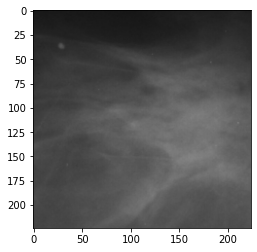

In [5]:
images = np.array(images)
labels = np.array(labels)
 
     

plt.imshow(images[19])
print(images[0].shape)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify = labels, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, stratify = y_test, random_state=50)

In [7]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(x_train.shape[1:])
base_pretrained_model = VGG16(input_shape = x_train.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
                        
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

final_model = Model(inputs = [in_lay], outputs = [out_layer])
final_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 7, 7, 512)    14714688    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 7, 7, 512)    2048        vgg16[1][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 64)     32832       batch_normalization[0][0]        
_____________________________

Epoch 1/30
3353/3353 [==============================] - 97s 26ms/step - loss: 0.2914 - acc: 0.8869 - val_loss: 0.2521 - val_acc: 0.8980

Epoch 00001: val_loss improved from inf to 0.25210, saving model to breast_cancer_weights.best.hdf5
Epoch 2/30
3353/3353 [==============================] - 76s 23ms/step - loss: 0.2471 - acc: 0.9024
Epoch 3/30
3353/3353 [==============================] - 75s 22ms/step - loss: 0.2178 - acc: 0.9125
Epoch 4/30
3353/3353 [==============================] - 75s 22ms/step - loss: 0.2080 - acc: 0.9188
Epoch 5/30
3353/3353 [==============================] - 75s 23ms/step - loss: 0.1969 - acc: 0.9220
Epoch 6/30
3353/3353 [==============================] - 75s 22ms/step - loss: 0.1887 - acc: 0.9263
Epoch 7/30
3353/3353 [==============================] - 75s 23ms/step - loss: 0.1807 - acc: 0.9290
Epoch 8/30
3353/3353 [==============================] - 75s 22ms/step - loss: 0.1730 - acc: 0.9319
Epoch 9/30
3353/3353 [==============================] - 76s 23ms/step 

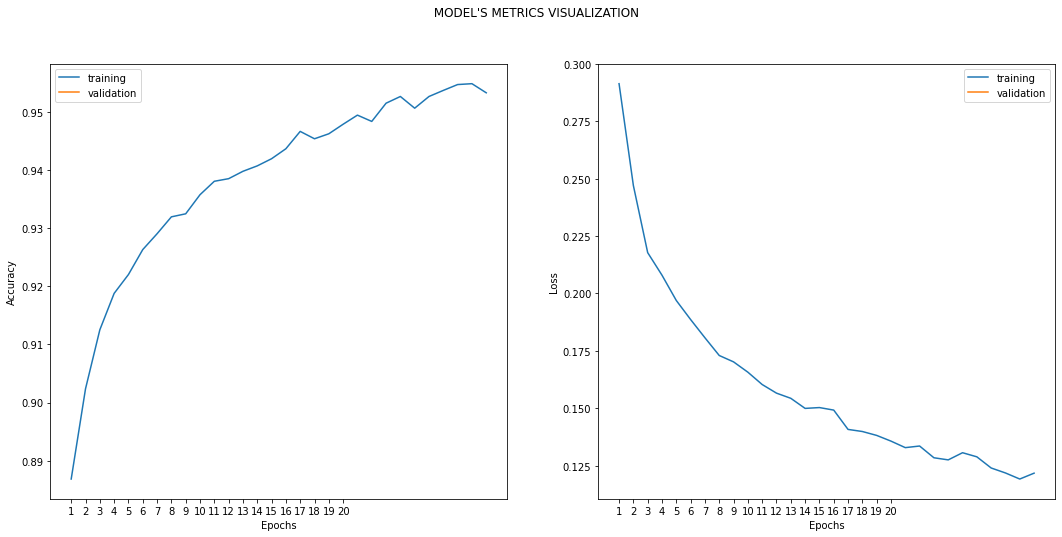

In [8]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('breast_cancer')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.00001)
#reduceLROnPlat = ReduceLROnPlateau()
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]
     

# Compile the model
final_model.compile(tf.keras.optimizers.Adam(learning_rate=.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])
     

# train the model

history = final_model.fit(x_train, y_train, 
                          steps_per_epoch=len(x_train)//8,
                          epochs=30,
                          validation_data = (x_val, y_val),
                          validation_steps = len(x_val)//8, 
                          callbacks = callbacks_list
                        )

loss_value , accuracy = final_model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))
     

# PLOTTING RESULTS (Train vs Validation) 
import matplotlib.pyplot as plt
import numpy as np

def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (18,8))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")
    ax1.set_xticks(np.arange(1, 21, 1))
    
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    #ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
    #plt.xticks(np.arange(1, 21, 1))
    ax2.set_xticks(np.arange(1, 21, 1))
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    #ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation']) 
    
    plt.show()
    fig.savefig('figure.png')
    
Train_Val_Plot(history.history['acc'],history.history['val_acc'],
               history.history['loss'],history.history['val_loss'])

In [9]:
predictions = final_model.layers[-2].output

model_feat = keras.Model(inputs = final_model.inputs ,outputs = predictions)

Extracted_features = model_feat.predict(x_test)
print(Extracted_features.shape)
     

train_image, valid_image, train_label, valid_label = train_test_split(Extracted_features, y_test, test_size=0.20, stratify = y_test, random_state=10)
val_img, test_img, val_lab, test_lab = train_test_split(valid_image, valid_label, test_size=0.5, 
                                                        stratify = valid_label, random_state=50)
     

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
_classifier = KNeighborsClassifier(n_neighbors=5)
     

_classifier.fit(train_image, train_label)
     

pred = _classifier.predict(test_img)
acc = accuracy_score(y_true = test_lab, y_pred = pred)
print(acc)

(3354, 128)
0.8660714285714286


In [10]:
final_features = Extracted_features
lab = np.array(y_test)
lab = lab.reshape(lab.shape[0], 1)
print(final_features.shape)
print(lab.shape)
np.savetxt("ext_features.csv", final_features, delimiter=",")
np.savetxt("labels.csv", lab, delimiter=",")
     

df = pd.read_csv('ext_features.csv', header=None)
df2 = pd.read_csv('labels.csv', header=None)

print(df.shape)
print(df2.shape)
total_features=df.shape[1]
x=df[df.columns[:total_features]]
y=df2[df2.columns[-1]].astype(int)

print(x.shape)
print(y.shape)
print(total_features)
     

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify = y, random_state=10)
print(train_x.shape)
print(test_y.shape)
     

(3354, 128)
(3354, 1)
(3354, 128)
(3354, 1)
(3354, 128)
(3354,)
128
(2683, 128)
(671,)


In [11]:
#adaptivebeta
import numpy as np
import pandas as pd
import math
import random
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler



swarm_size = 20   #population size
max_iterations = 100
omega = 0.2  #used in the fitness function
delta=0.2   #to set an upper limit for including a slightly worse particle in LAHC


def mutate(agent):
  percent=0.2
  numChange=int(total_features*percent)
  pos=np.random.randint(0,total_features-1,numChange) #choose random positions to be mutated
  agent[pos]=1-agent[pos] #mutation
  return agent

def LAHC(particle):
            _lambda = 15 #upper limit on number of iterations in LAHC
            target_fitness = find_fitness(particle) #original fitness
            for i in range(_lambda):
                    new_particle = mutate(particle) #first mutation
                    temp = find_fitness(new_particle)
                    if temp < target_fitness:
                        particle = new_particle.copy() #updation
                        target_fitness = temp
                    elif (temp<=(1+delta)*target_fitness):
                        temp_particle = new_particle.copy()
                        for j in range(_lambda):
                            temp_particle1 = mutate(temp_particle) #second mutation
                            temp_fitness = find_fitness(temp_particle1)
                            if temp_fitness < target_fitness:
                                target_fitness=temp_fitness
                                particle=temp_particle1.copy() #updation
                            break
            return particle   

def randomwalk(agent):
    percent = 30
    percent /= 100
    neighbor = agent.copy()
    size = np.shape(agent)[0]
    upper = int(percent*size)
    if upper <= 1:
        upper = size
    x = random.randint(1,upper)
    pos = random.sample(range(0,size - 1),x)
    for i in pos:
        neighbor[i] = 1 - neighbor[i]
    return neighbor

def adaptiveBeta(agent):
    bmin = 0.1 #parameter: (can be made 0.01)
    bmax = 1
    maxIter = 10 # parameter: (can be increased )
    
    agentFit = find_fitness(agent)
    for curr in range(maxIter):
        neighbor = agent.copy()
        size = np.shape(neighbor)[0]
        neighbor = randomwalk(neighbor)

        beta = bmin + (curr / maxIter)*(bmax - bmin)
        for i in range(size):
            random.seed( time.time() + i )
            if random.random() <= beta:
                neighbor[i] = agent[i]
        neighFit = find_fitness(neighbor)
        if neighFit <= agentFit:
            agent = neighbor.copy()
            


    return agent

def find_fitness(particle):
            features = []
            for x in range(len(particle)):
                    if particle[x]>=0.5: #convert it to zeros and ones
                        features.append(df.columns[x])
            if(len(features)==0):
                        return 10000
            new_x_train = train_x[features].copy()
            new_x_test = test_x[features].copy()

            _classifier = KNeighborsClassifier(n_neighbors=5)
            _classifier.fit(new_x_train, train_y)
            predictions = _classifier.predict(new_x_test)
            acc = accuracy_score(y_true = test_y, y_pred = predictions)
            fitness = acc
            err=1-acc
            num_features = len(features)
            fitness =  alpha*err + (1-alpha)*(num_features/total_features)

            return fitness

def transfer_func(velocity): #to convert into an array of zeros and ones
            t=[]
            for i in range(len(velocity)):
                    t.append(abs(velocity[i]/(math.sqrt(1+velocity[i]*velocity[i])))) #transfer function inside paranthesis
            return t

#initialize swarm position and swarm velocity of SSD
swarm_vel = np.random.uniform(low=0, high=1, size=(swarm_size,total_features))

swarm_pos = np.random.uniform(size=(swarm_size,total_features))
swarm_pos = np.where(swarm_pos>=0.5,1,0)

c = 100
alpha= 0.9

gbest_fitness=100000
pbest_fitness = np.zeros(swarm_size)
pbest_fitness.fill(np.inf)  #initialize with the worse possible values
pbest = np.empty((swarm_size,total_features))
gbest = np.empty(total_features)
pbest.fill(np.inf)
gbest.fill(np.inf)

for itr in range(max_iterations):

                for i in range(swarm_size):
                  
                    swarm_pos[i] = adaptiveBeta(swarm_pos[i]) #for ABHC local search
                    #swarm_pos[i] = LAHC(swarm_pos[i]) #for LAHC local search
                    fitness = find_fitness(swarm_pos[i])

                    if fitness < gbest_fitness:

                        gbest=swarm_pos[i].copy() #updating global best
                        gbest_fitness=fitness



                    if fitness < pbest_fitness[i]:
                        pbest[i] = swarm_pos[i].copy() #updating personal best
                        pbest_fitness[i]=fitness

                    r1 = random.random()
                    r2 = random.random()

          #updating the swarm velocity
                    if r1 < 0.5:
                        swarm_vel[i] = c*math.sin(r2)*(pbest[i]-swarm_pos[i]) +math.sin(r2)* (gbest-swarm_pos[i])
                    else:
                        swarm_vel[i] = c*math.cos(r2)*(pbest[i]-swarm_pos[i]) + math.cos(r2)*(gbest-swarm_pos[i])
                    
          #decaying value of c
                    alpha= 0.9
                    c=alpha*c;
          
          #applying transfer function and then updating the swarm position
                    t = transfer_func(swarm_vel[i])
                    for j in range(len(swarm_pos[i])):
                        if(t[j] < 0.5):
                            swarm_pos[i][j] = swarm_pos[i][j]
                        else:
                            swarm_pos[i][j] = 1 - swarm_pos[i][j]



selected_features = gbest
print(gbest_fitness)
            
number_of_selected_features = np.sum(selected_features)
print("#",number_of_selected_features)

features=[]
for j in range(len(selected_features)):
                if selected_features[j]==1:
                        features.append(df.columns[j])
new_x_train = train_x[features]
new_x_test = test_x[features]

_classifier = KNeighborsClassifier(n_neighbors=5)
_classifier.fit(new_x_train, train_y)
predictions = _classifier.predict(new_x_test)
acc = accuracy_score(y_true = test_y, y_pred = predictions)
pre = precision_score(y_true = test_y, y_pred = predictions,average=None)
rec = recall_score(y_true = test_y, y_pred = predictions, average=None)
result = classification_report(y_true = test_y, y_pred = predictions, digits=5)
fitness = acc
print("Acc:",fitness)
print("Precision:", pre)
print("Recall:",rec)
print(result)
print("\n\n")

0.09150405178837559
# 33
Acc: 0.9269746646795827
Precision: [0.94069193 0.796875  ]
Recall: [0.97773973 0.5862069 ]
              precision    recall  f1-score   support

           0    0.94069   0.97774   0.95886       584
           1    0.79688   0.58621   0.67550        87

    accuracy                        0.92697       671
   macro avg    0.86878   0.78197   0.81718       671
weighted avg    0.92205   0.92697   0.92212       671






# Training Procedure

0.7819733112895607
0.7819733112895607


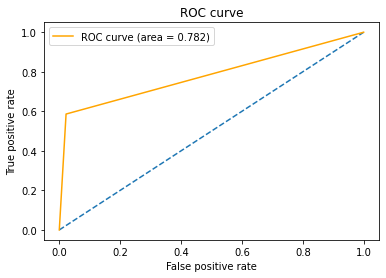

In [12]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(test_y, predictions)

auc = auc(fpr, tpr)
sc = roc_auc_score(test_y, predictions)
print(auc)
print(sc)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='ROC curve (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
     